In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import h5py
import math
from sklearn.naive_bayes import *
from sklearn.metrics import confusion_matrix

In [2]:
 f = h5py.File('Cicero_09102014_sessInfo.mat','r');
#f = h5py.File('Gatsby_08022013_sessInfo.mat','r');

In [3]:
mazeType  = ''.join(chr(i) for i in np.squeeze(f['sessInfo']['Position']['MazeType'][()])); 
time      = np.squeeze(f['sessInfo']['Position']['TimeStamps']);
pos2DRaw  = np.squeeze(f['sessInfo']['Position']['TwoDLocation']);
framerate = 1/np.mean(time[1:]-time[:-1]) 
T         = len(time);

In [4]:
pos2D    = np.copy(pos2DRaw);
x = lambda z: z.nonzero()[0];
for i in range(0,2):
    nans = np.isnan(pos2D[i,:]);
    pos2D[i,nans] = np.interp(x(nans), x(~nans), pos2D[i,~nans]);

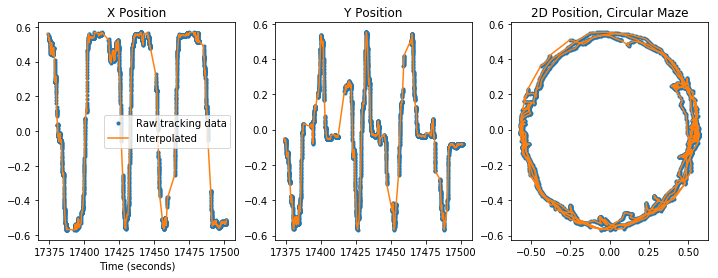

In [5]:
fig,ax = plt.subplots(1,3,figsize=(12,4));
inds = range(5000,10000);
ax[0].plot(time[inds],pos2DRaw[0,inds],'.',label='Raw tracking data');
ax[0].plot(time[inds],pos2D[0,inds],label='Interpolated');
ax[0].legend();
ax[0].set_title('X Position');
ax[0].set_xlabel('Time (seconds)')

ax[1].plot(time[inds],pos2DRaw[1,inds],'.',label='Raw tracking data');
ax[1].plot(time[inds],pos2D[1,inds],label='Interpolated');
ax[1].set_title('Y Position');
ax[0].set_xlabel('Time (seconds)')

ax[2].plot(pos2DRaw[0,inds],pos2DRaw[1,inds],'.',label='Raw tracking data');
ax[2].plot(pos2D[0,inds],pos2D[1,inds],label='Interpolated');
ax[2].set_title('2D Position, ' + mazeType);

In [6]:
linearPos = np.arctan2(pos2D[0,:-1],pos2D[1,:-1]); # for circular mazes

In [7]:
spTimes = f['sessInfo']['Spikes']['SpikeTimes'][0];
spIDs   = f['sessInfo']['Spikes']['SpikeIDs'][0];
cells   = np.unique(spIDs);
N       = len(cells);

In [8]:
mazeTimes    = np.logical_and(spTimes>=min(time), spTimes<=max(time));
mazeSpikes   = spTimes[mazeTimes];
mazeIDs      = spIDs[mazeTimes];

In [9]:
raster = np.zeros((N+1,T-1));
for ind,i in enumerate(cells.T):
    raster[ind,:],_ = np.histogram(mazeSpikes[mazeIDs==i],time);

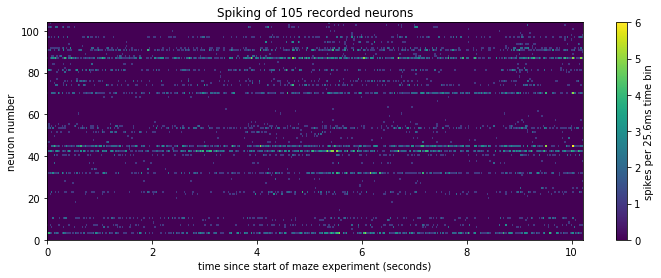

In [10]:
plt.figure(figsize=(12,4));
inds = range(0,400);
plt.imshow(raster[:,inds],extent=[time[inds[0]]-time[0],time[inds[-1]]-time[0],0,N-1],aspect='auto');
plt.title('Spiking of ' + str(N) + ' recorded neurons');
plt.xlabel('time since start of maze experiment (seconds)');
plt.ylabel('neuron number');
h=plt.colorbar();
h.set_label('spikes per ' + "{:.1f}".format(1/framerate*1000) + 'ms time bin');

In [11]:
time = time - time[0];
del f, spTimes, spIDs;

In [12]:
def smooth(a,WSZ):
    # a: NumPy 1-D or 2-D array containing the data to be smoothed (row-wise)
    # WSZ: smoothing window size needs, which must be odd number
    aSm = np.zeros(a.shape);
    if(len(a.shape)==1):
        out0 = np.convolve(a,np.ones(WSZ,dtype=int),'valid')/WSZ;
        r = np.arange(1,WSZ-1,2);
        start = np.cumsum(a[:WSZ-1])[::2]/r;
        stop = (np.cumsum(a[:-WSZ:-1])[::2]/r)[::-1];
        aSm = np.concatenate((  start , out0, stop  ));
    else:
        for i in range(0,a.shape[0]):
            out0 = np.convolve(a[i,:],np.ones(WSZ,dtype=int),'valid')/WSZ;
            r = np.arange(1,WSZ-1,2);
            start = np.cumsum(a[i,:WSZ-1])[::2]/r;
            stop = (np.cumsum(a[i,:-WSZ:-1])[::2]/r)[::-1];
            aSm[i,:] = np.concatenate((  start , out0, stop  ));
    return aSm;

In [13]:
from sklearn.decomposition import *

velocity = np.sqrt((pos2D[0,2:]-pos2D[0,:-2])**2 + (pos2D[1,2:]-pos2D[1,:-2])**2)

In [14]:
pca = PCA(n_components=4, whiten=True)
sraster = smooth(raster, 201)
components = pca.fit_transform(np.transpose(sraster))

In [15]:
sum(pca.explained_variance_ratio_)

0.8253592124277528

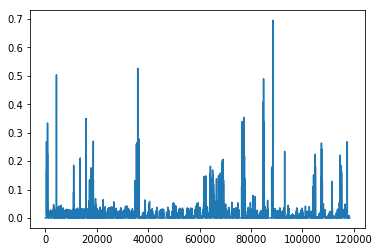

In [17]:
    plt.plot(range(len(velocity)), velocity)
    plt.show()

In [18]:
from sklearn.metrics import mean_squared_error
from math import sqrt

errors = []
corr = []
for i in range(len(components[0])):
    errors.append(sqrt(mean_squared_error(components[:,i][1:], velocity)))
    corr.append(np.corrcoef(components[:,i][1:], velocity))

In [20]:
transformer = FactorAnalysis(n_components=4)
fa_components = transformer.fit_transform(np.transpose(sraster))

In [22]:
transformer.loglike_

[-11249177.273420857,
 33609366.48576643,
 34308888.190081604,
 34375374.663260266,
 34383551.69182094,
 34385034.12673494,
 34385410.143544614,
 34385473.623379685,
 34385547.242708586,
 34385580.81715639,
 34385576.682461366]

In [29]:
transformer.score(np.transpose(sraster))

290.51959963250357

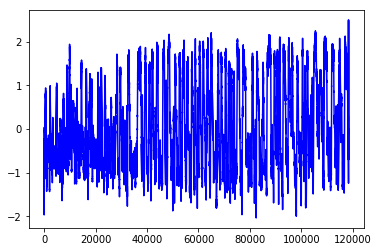

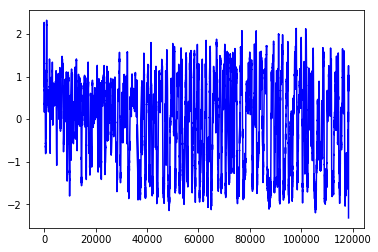

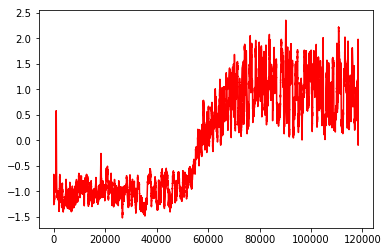

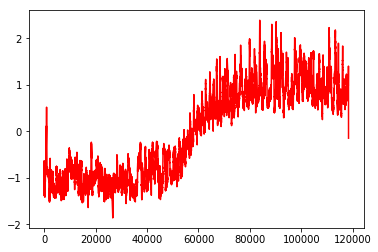

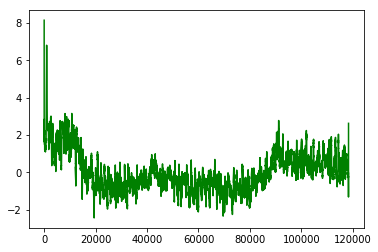

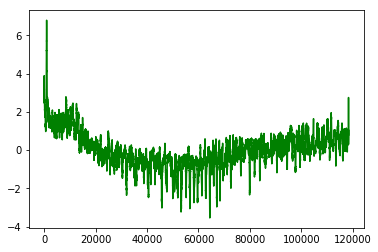

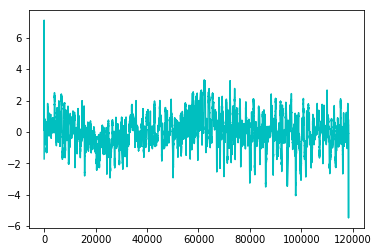

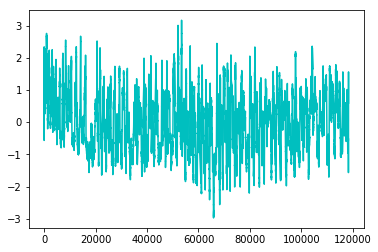

In [27]:
color = ['b', 'r', 'g', 'c']
for i in range(len(fa_components[0])):
    plt.plot(range(len(components[:,0])), components[:,i], color[i])
    plt.show()
    plt.plot(range(len(fa_components[:,0])), fa_components[:,i], color[i])
    plt.show()